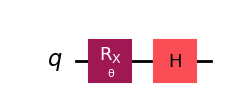

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from gymnasium.spaces import Box
from rl_qoc import (CustomPPO,
                    ContextAwareQuantumEnvironment,
                    RescaleAndClipAction,
                    QiskitConfig,
                    GateTargetConfig, QEnvConfig,
                    ExecutionConfig,
                    )
                    

θ = Parameter('θ')
qc = QuantumCircuit(1)
qc.rx(θ, 0)
qc.h(0)

qc.draw('mpl')

In [2]:
θ_val = np.pi

In [17]:
from qiskit_aer.noise import NoiseModel,coherent_unitary_error
from qiskit.circuit.library import RXGate
γ = 0.1
noisy_unitary = RXGate(γ*θ_val).to_matrix()
noise_model = NoiseModel(basis_gates=["h", "rx", "rz", "t", "s", "sdg", "tdg", "u"])
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(noisy_unitary), 'rx')

In [18]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
backend = GenericBackendV2(1, ["h", "rx", "rz", "t", "s", "sdg", "tdg", "u", 'reset'],
                           calibrate_instructions=True)
backend = AerSimulator.from_backend(backend, noise_model=noise_model)

In [19]:
# Define target gate
target = GateTargetConfig(physical_qubits=[0],
                          gate='h')


In [20]:
# Define parametrized circuit

def apply_parametrized_circuit(qc: QuantumCircuit, params, q_reg, **kwargs):
    my_qc = qc.copy_empty_like(name="h_cal")
    
    my_qc.ry(-np.pi/2 + params[0], q_reg[0])
    my_qc.z(q_reg[0])
    
    qc.append(my_qc.to_gate(label=my_qc.name), q_reg)

qiskit_config = QiskitConfig(apply_parametrized_circuit,
                             backend,
                             parametrized_circuit_kwargs={"target": target, "backend": backend})

In [21]:
# Define the quantum environment
action_space = Box(low=-np.pi, high=np.pi, shape=(1,), dtype=np.float32)
env_metadata = {"γ": γ,
                "θ": θ_val}
training_config = QEnvConfig(target=target,
                             backend_config=qiskit_config,
                             reward_config='channel',
                             execution_config=ExecutionConfig(batch_size=32,
                                                              sampling_paulis=50,
                                                              n_shots=1024,
                                                              n_reps=1
                                                              ),
                             action_space=action_space,
                             env_metadata= env_metadata
                             )

In [22]:
q_env = ContextAwareQuantumEnvironment(training_config, 
                                       circuit_context=qc.assign_parameters({θ: θ_val}))
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

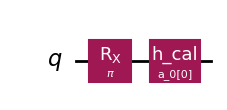

In [23]:
q_env.circuits[0].draw('mpl')

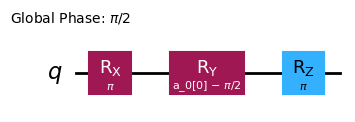

In [24]:
from qiskit import transpile
transpile(q_env.circuits[0], basis_gates=["ry", "rz", 'sx', 'rx']).draw('mpl')

In [34]:
from rl_qoc.agent import PPOConfig

ppo_config = PPOConfig.from_yaml("agent_config.yaml")


In [35]:
from rl_qoc.agent import TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(ppo_config, rescaled_env, save_data=False)
total_updates = 100
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

run_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

In [36]:
print(q_env.backend.target)

Target: Generic Target with 1 qubits
Number of qubits: 1
Instructions:
	h
		(0,):
			Duration: 3.1746e-08 sec.
			Error Rate: 9.32363e-05
			With pulse schedule calibration
	rx
		(0,):
			Duration: 3.8406e-08 sec.
			Error Rate: 9.89496e-05
			With pulse schedule calibration
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	t
		(0,):
			Duration: 3.219e-08 sec.
			Error Rate: 9.98471e-05
			With pulse schedule calibration
	s
		(0,):
			Duration: 5.55e-08 sec.
			Error Rate: 9.39709e-05
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 4.0626e-08 sec.
			Error Rate: 9.31974e-05
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 5.9718e-08 sec.
			Error Rate: 9.0325e-05
			With pulse schedule calibration
	u
		(0,):
			Duration: 5.217e-08 sec.
			Error Rate: 9.42019e-05
			With pulse schedule calibration
	reset
		(0,):
	delay
		(0,):
	measure
		(0,):
			Duration: 9.85458e-07 sec.
			Error Rate: 0.00385324
			With pulse schedule calib

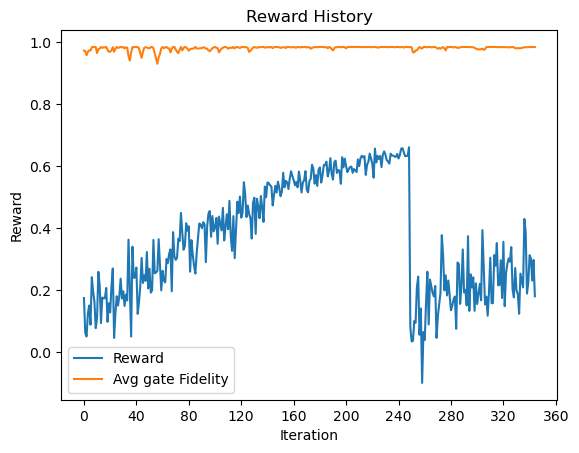

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.983358894464617
Hardware runtime taken: 446009344456.6532
Sending Estimator job...
Time for running 0.013106822967529297
Finished Estimator job
Reward (avg): 0.2490623083945826 Std: 0.3389979167410498
Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9833688602066945
Hardware runtime taken: 447221760457.89453
Sending Estimator job...
Time for running 0.013383865356445312
Finished Estimator job
Reward (avg): 0.326980070403369 Std: 0.35942608687117816
Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9833337557207943
Hardware runtime taken: 448532480459.2365
Sending Estimator job...
Time for running 0.012317895889282227
Finished Estimator job
Reward (avg): 0.2727548095170299 Std: 0.376870653693261


{'avg_reward': [0.07811293749194417,
  0.03367144475393804,
  0.03546755932158967,
  0.09956460144800541,
  0.09377053764255622,
  0.20767244823983105,
  0.24256604519077846,
  0.055243848025837594,
  0.1398909567445452,
  -0.10018703741191368,
  0.06393317786259173,
  0.03869147998324668,
  0.16078031325121078,
  0.2586245224296257,
  0.0884554163756257,
  0.23317978022459468,
  0.21079865300946232,
  0.18995318857836158,
  0.17855208656848115,
  0.21261506113984316,
  0.0450939633660409,
  0.11538608105479259,
  0.1517400741159203,
  0.19002076215246327,
  0.37647671694481766,
  0.31098048107370635,
  0.1985141102555545,
  0.24693430011719303,
  0.1819356241107336,
  0.22997878351500178,
  0.1812486707305759,
  0.1342046718212668,
  0.1493281034755516,
  0.16997224053730722,
  0.17833209944250955,
  0.07434522561898863,
  0.2881827236182365,
  0.28330448857867885,
  0.15467656565333493,
  0.213776841522066,
  0.33047263984513364,
  0.19174691937094185,
  0.2000813326203868,
  0.14977

<Figure size 640x480 with 0 Axes>

In [37]:
ppo_agent.train(run_config, train_settings)

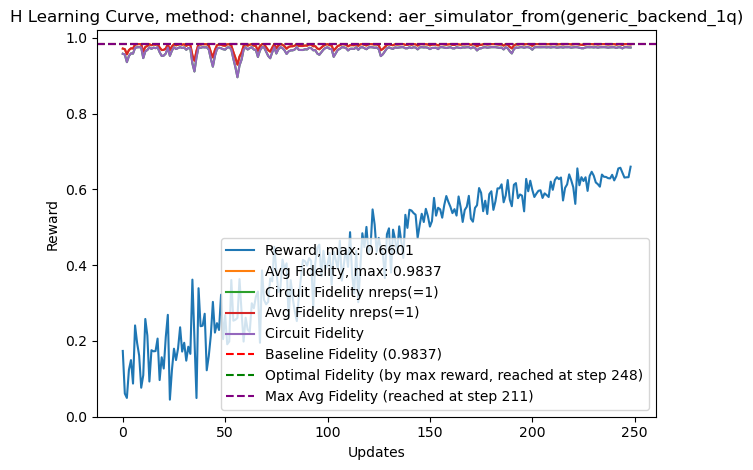

In [29]:

# Plotting the learning curve
import matplotlib.pyplot as plt
reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)
baseline_fidelity = np.round(q_env.simulate_circuit(q_env.circuits[0], np.zeros((1, 1)), update_env_history=False), 4)[0]

plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
)
plt.plot(
    q_env.circuit_fidelity_history_nreps,
    label=f"Circuit Fidelity nreps(={q_env.n_reps})",
)
plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity (by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity (reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env.config.backend.name if q_env.config.backend is not None else 'No backend'}"
)
plt.ylim(0., 1.02)
plt.legend()
plt.tight_layout()

In [16]:
q_env.optimal_action

array([0.04207047], dtype=float32)